## Valley2 DPO (Direct Preference Optimization)

* From ByteDance research
* Ranked #27 in OpenCompass multimodal academic leaderboard (https://rank.opencompass.org.cn/leaderboard-multimodal)


In [1]:
import sys
import os
from transformers import AutoModel, AutoProcessor
import torch

# Add the desired directory to the Python path
sys.path.append(os.path.abspath('/data/students/earl/llava-dissector/Valley2-DPO'))

#from valley_eagle_chat import ValleyEagleChat
import urllib
from io import BytesIO
from PIL import Image

device = "cuda:5"

model_path = '/data/students/earl/llava-dissector/Valley2-DPO'
model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True, 
    device_map='auto').eval()#.to(device)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)



/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


## Extract the object and visualize

[0.34, 0.32, 0.53, 0.74]
Bounding boxes: [[0.34, 0.32, 0.53, 0.74]]


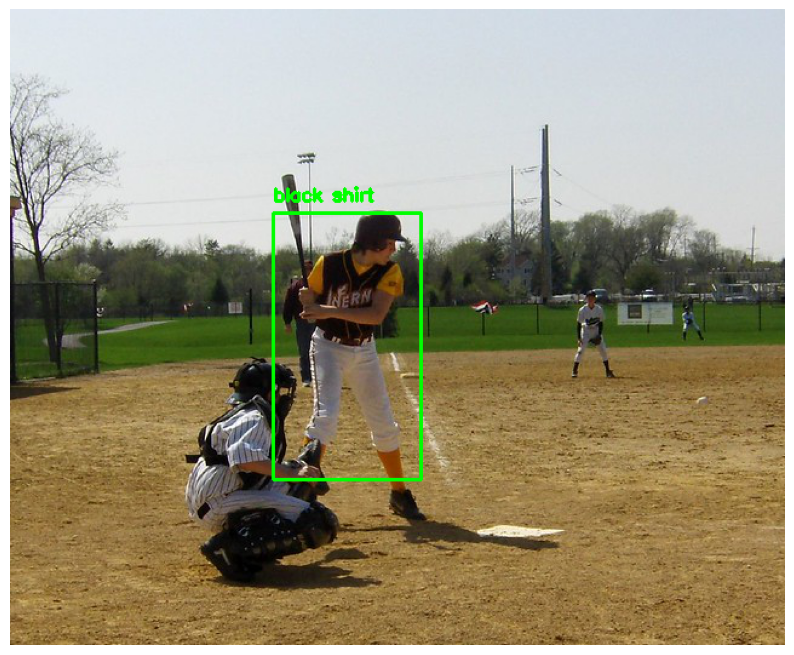

In [26]:
cls = "black shirt"
model.threshold = None #-6.0

text=f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image'
url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
img = urllib.request.urlopen(url=url, timeout=5).read()
img = Image.open(BytesIO(img)).convert("RGB")
res = processor(
    {
        "conversations": 
        [
            {"role": "system", "content": "You are Valley, developed by ByteDance. Your are a helpfull Assistant. You provide the bounding box coordinates of all instances of an object class when asked."},
            {"role": "user", "content": {text}},
            #{"role": "user", "content": "Describe the given image."},
            #{"role": "user", "content": f"Provide the bounding box coordinates of {cls}"},
        ], 
        "images": [img]
    }, 
    inference=True
)

with torch.inference_mode():
    #model.to(dtype=torch.float16, device=device)
    output_ids = model.generate(
        input_ids=res["input_ids"].to(device),
        #images=[[item.to(dtype=torch.float16, device=device) for item in img] for img in res["images"]],
        images=[[item.to(dtype=torch.bfloat16) for item in img] for img in res["images"]],
        image_sizes=res["image_sizes"],
        #pixel_values=res["pixel_values"].to(dtype=torch.float16, device=device),
        #image_grid_thw=res["image_grid_thw"].to(device),
        pixel_values=res["pixel_values"].to(dtype=torch.bfloat16),#, device=device),
        image_grid_thw=res["image_grid_thw"],#.to(device),   
        do_sample=False,
        max_new_tokens=1024,
        repetition_penalty=1.0,
        return_dict_in_generate=True,
        output_scores=True,
    )
input_token_len = res["input_ids"].shape[1]
generation_text = processor.batch_decode(output_ids.sequences[:, input_token_len:])[0]
generation_text = generation_text.replace("<|im_end|>", "")
print(generation_text)

## Visualize using cv2

# Extract the bounding box coordinates from the output
# Make sure the list is a list of floats
# Example output: "Bounding box coordinates: [[x1, y1, x2, y2], [x1, y1, x2, y2]]"
import re
import matplotlib.pyplot as plt

#pattern = r'\[\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*\]'
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, generation_text)
bounding_boxes = [
    [float(coord) for coord in match if coord != '']
    for match in matches
]
print("Bounding boxes:", bounding_boxes)

# Visualize using cv2
import cv2
import numpy as np
img_cv = np.array(img)
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
